In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.color import rgb2gray
import skimage.segmentation as seg
import skimage.color as color
import matplotlib.pyplot as plt
import cv2


In [37]:
#importamos el modulo que contiene las funciones

import segmentadores as s
#path de la imagen

imgPath='imagenes/cocheBlanco.jpg'
img = io.imread(imgPath)


#path de la imagen con el ground truth

imgTruth='imagenes/cocheBlanco_GroundTruth.jpg'
imgTruth = io.imread(imgTruth)


Visualizamos la imagen con el que se va a trabajar y la imagen que contiene el ground truth:

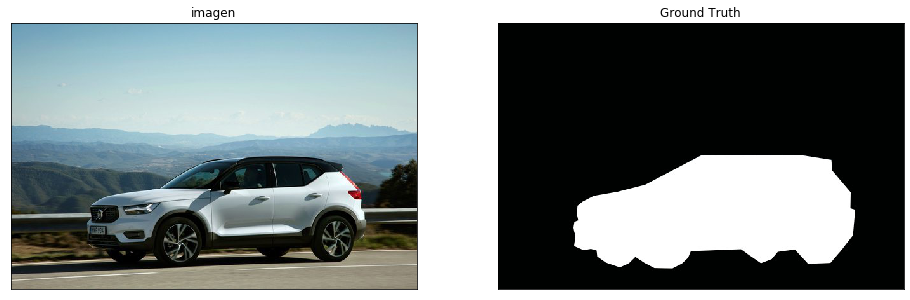

In [38]:
s.showImages(img,'imagen',imgTruth,'Ground Truth')

El siguiente rectángulo se utilizara para más adelante evaluar la intersection over unión

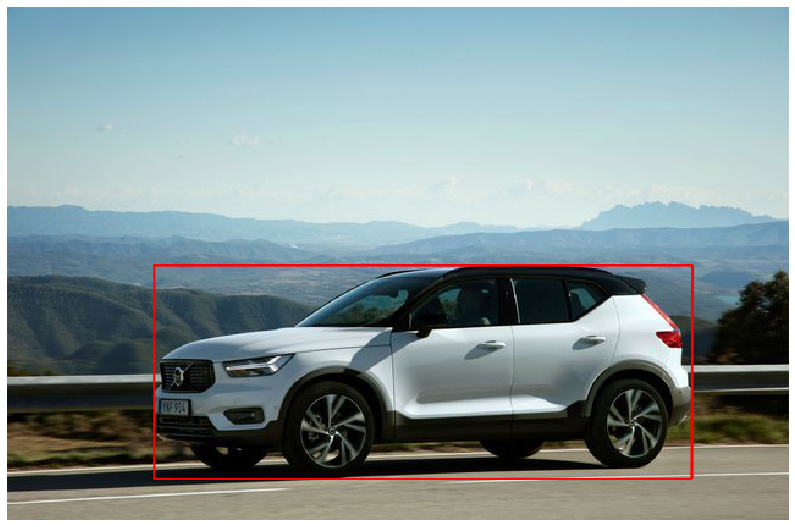

In [39]:
#valores máximos y mínimos de las filas y columnas de los bordes del coche.

arrayEvaluacion=imgTruth[:,:,0]
TruthRectangle=s.getVertices(arrayEvaluacion)

#llamamos a la función dibujarCuadrado para obtener puntos del cuadrado ideal

fTruth,cTruth=s.dibujarCuadrado(TruthRectangle)

# Visualizamos el cuadrado ideal
fig, ax = s.image_show(img)
ax.plot(fTruth,cTruth, 'r', lw=2)

#### ALGORITMO IÑIGO

C:\Users\luisg\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  if __name__ == '__main__':


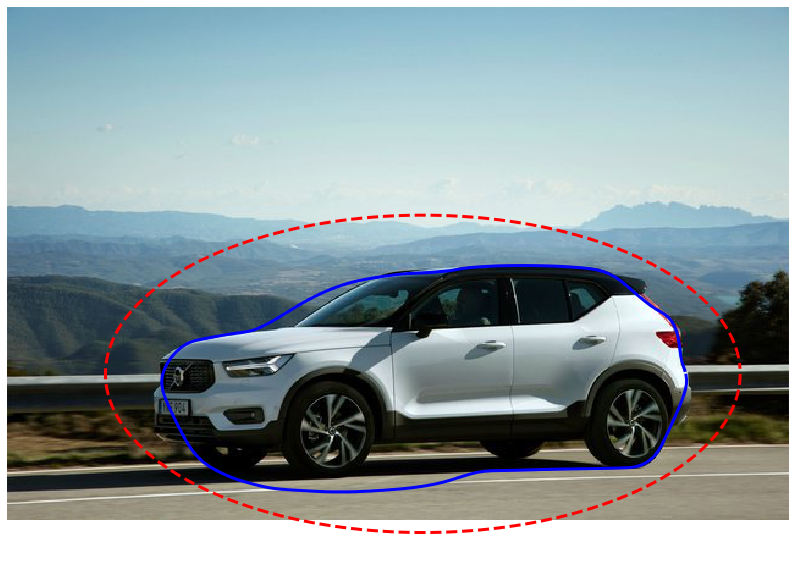

In [40]:
# Definimos manualmente el espacio donde se encuentra el  objeto que se quiere segmentar

img = io.imread(imgPath)
points = s.circle_points(200, [300, 340], 260,130)[:-1]

# Aplicamos el segmentador GVF en la zona que hemos definido manualmente

image_gray = rgb2gray(img)
snake = seg.active_contour(image_gray, points,alpha=0.1, beta=0.7, gamma=0.06)
# Visualizamos los resultados obtenidos. Lo que aparece en azul es la imagen segmentada y en rojo, la zona que hemos definido 
# manualmente para que el algoritmo GVF trabajase en el

fig, ax = s.image_show(img)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

Evaluación

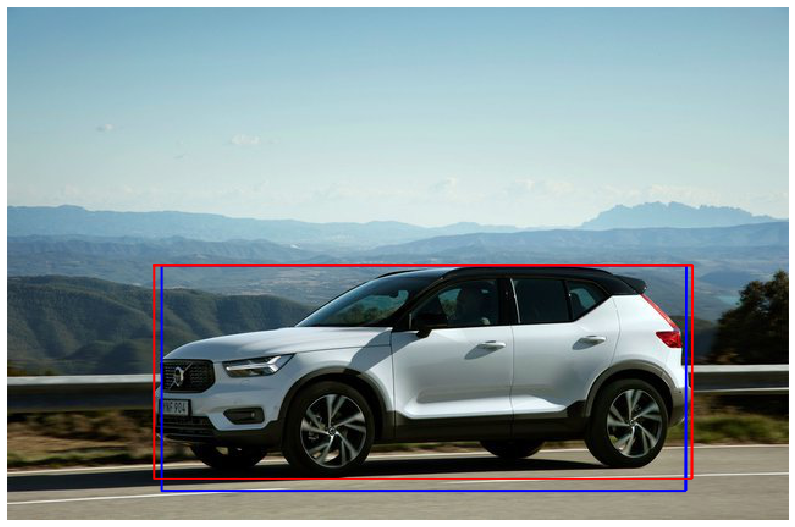

In [41]:
# Obtenemos los vértices del rectángulo predicho

predRectangle1=s.getRectangleValues(snake)

# Llamamos a la función dibujarCuadrado para obtener puntos del cuadrado predicho

fPredicted,cPredicted=s.dibujarCuadrado(predRectangle1)

# Llamamos a la función dibujarCuadrado para obtener puntos del cuadrado ideal

fTruth,cTruth=s.dibujarCuadrado(TruthRectangle)

# Vemos la intersection over union dibujada. El azul son los valores predichos y el rojo los valores reales
fig, ax = s.image_show(img)
ax.plot(fPredicted, cPredicted, 'b', lw=2);
ax.plot(fTruth,cTruth, 'r', lw=2)

In [42]:
print("Intersection over union del algoritmo de Iñigo:" +'\n')

iou_inigo = s.bb_intersection_over_union(predRectangle1,TruthRectangle)*100
print(iou_inigo, '%')

Intersection over union del algoritmo de Iñigo:

92.39238995395971 %


#### ALGORITMO LUIS

In [32]:
# Usaremos el segmentador de la libreria Pixellib que hemos descrito en el jupyter de Luis

segvalues, output= s.segmentador_Luis(imgPath,'salida.jpg')

C:\Users\luisg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Processed image saved successfully in your current working directory.


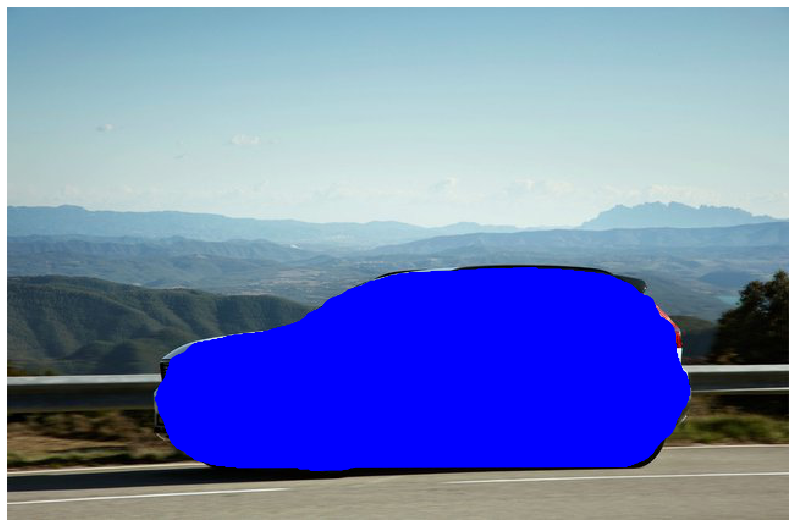

In [43]:
# Vamos a visualizar la máscara conformada por los píxeles que ha segmentado la función anterior.

mask=segvalues['masks']
maskValues = np.column_stack(np.where(mask))
maskValues = np.delete(maskValues, 2, 1)
maskValues= np.array((maskValues[:,1],maskValues[:,0])).T
fig, ax = s.image_show(img)
ax.plot(maskValues[:, 0], maskValues[:, 1], 'b', lw=3);

Evaluación

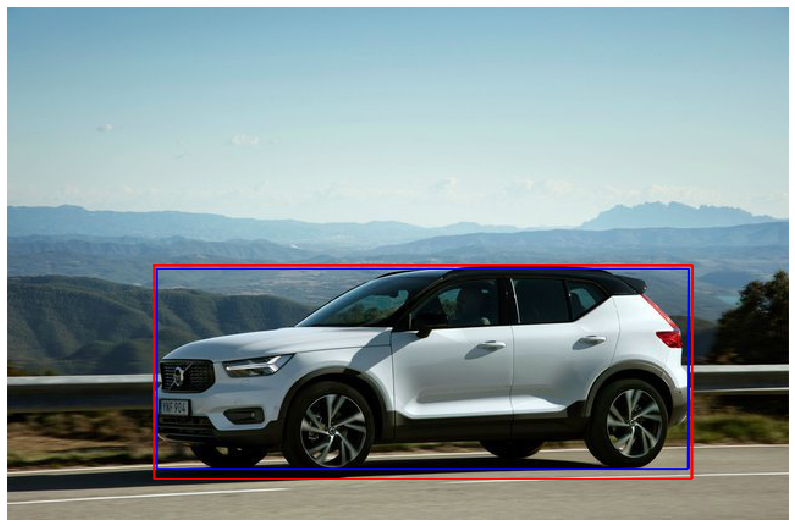

In [44]:
# Obtenemos los vértices del rectángulo predicho

predRectangle2=s.getRectangleValues(maskValues)

# Llamamos a la función dibujarCuadrado para obtener puntos del cuadrado predicho
fPredicted,cPredicted=s.dibujarCuadrado(predRectangle2)

# Llamamos a la función dibujarCuadrado para obtener puntos del cuadrado ideal
fTruth,cTruth=s.dibujarCuadrado(TruthRectangle)

# Vemos la intersection over union dibujada. El azul son los valores predichos y el rojo los valores reales

fig, ax = s.image_show(img)
ax.plot(fPredicted, cPredicted, 'b', lw=2);
ax.plot(fTruth,cTruth, 'r', lw=2)

In [46]:
print("Intersection over union del algoritmo de Luis:" +'\n')
iou_luis = s.bb_intersection_over_union(predRectangle2,TruthRectangle)*100
print(iou_luis, '%')

Intersection over union del algoritmo de Luis:

92.68947963800905 %


#### Algoritmo alberto

[INFO] La inferencia tardó 0.7041 segundos


(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

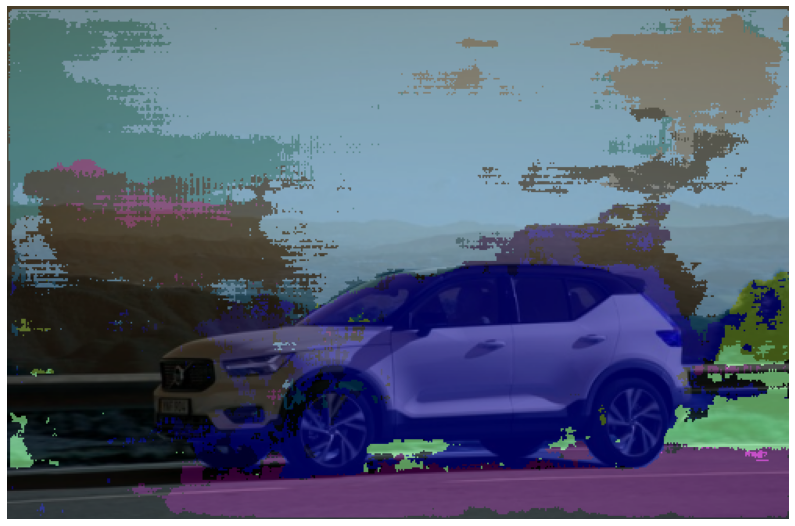

In [12]:
j,mask=s.segmentador_alb(imgPath,'salida.jpg')
s.image_show(j)

Debido a la hospitalización de Alberto y al viaje de trabajo de Guillermo, hemos considerado solo los segmentadores de Luis e Iñigo para usar el sistema de votaciones, ya que son los únicos que han llegado a la parte de integrar una métrica como IoU. No obstante, nos gustaría señalar el esfuerzo de Alberto, que aún estando ingresado, ha buscado información, ha creado su segmentador y ha hecho todo lo que estaba en su mano para ayudarnos. Esperemos que se recupere pronto.

#### Union de los algoritmos

Para poder realizar el sistema de votaciones, primero separamos lo que el algoritmo ha identificado como coche y lo que no. Para ello pintamos de negro lo que no se ha definido como coche y pintamos de blanco lo que sí en cada uno de los algoritmos.

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2750ba886c8>)

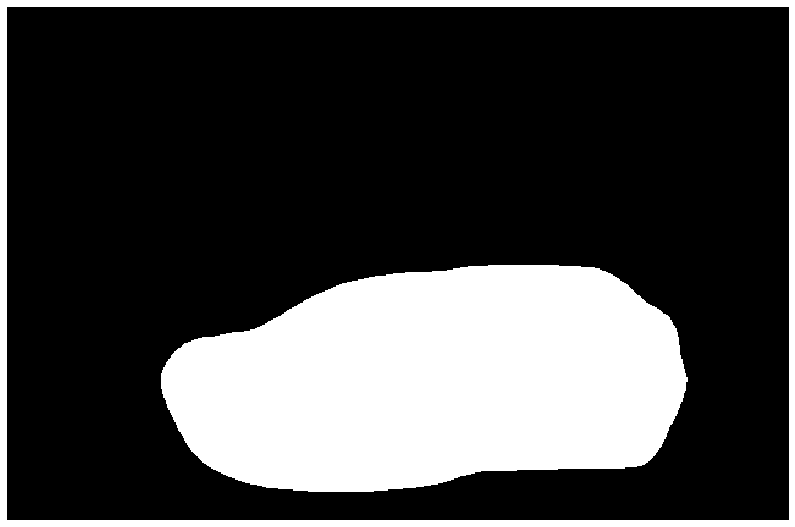

In [15]:
# Algoritmo Iñigo
snake=snake.astype(int)
result1 = np.zeros(img.shape).astype(img.dtype) # Creamos una imagen de un solo canal para que sea negro
cv2.fillPoly(result1, pts =[snake], color=[255,255,255])
result1=result1[:,:,0] # Porque nos vale trabajar con un solo canal
s.image_show(result1)

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27515a366c8>)

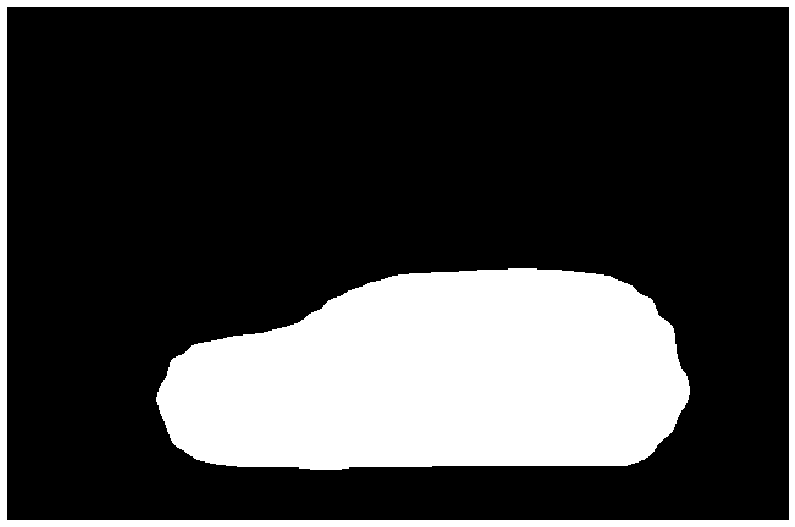

In [18]:
# Algoritmo Luis
result2 = np.zeros(img.shape).astype(img.dtype) # create a single channel 200x200 pixel black image 
cv2.fillPoly(result2, pts =[maskValues], color=[255,255,255])
result2=result2[:,:,0] #porque nos vale trabajar con un solo canal
s.image_show(result2)

Dado que solo se han desarrollado dos algoritmos el sistema de votaciones no tiene demasiado impacto. El sistema de votaciones funciona de la siguiente manera:

-Se comparan las imagenes obtenidas mediante los dos algoritmos.

-Solamente existen dos valores posibles de píxel: es coche (pixel blanco, 255) y no es coche(pixel negro,0)

-En caso de empate en la votación se clasificara el pixel como coche

In [49]:
def obtenerSegmentacionConjunta2(im1,im2):
    '''
    Función que recibe dos imágenes segmentadas mediante el algoritmo de Iñigo (im1) y Luis (im2) y guarda una imagen final
    (finalImage), segmentada mediante un sistema de voto. EL sistema funciona de forma que si los segmentadores difieren en un
    píxel, el segmentador con mejor puntuación IoU (el de Luis), sea el que prevalezca.
    
    '''
    finalImage = np.zeros(im1.shape).astype(im1.dtype) # create a single channel 200x200 pixel black image 
    for row in range(len(im1)):
        for col in range(len(im1[row])):
            # Si una imagen ha detectado un pixel como coche (==255) y la otra no, haremos caso a la que mayor
            # puntuación IoU tiene, la de Luis:
            
            if(im1[row][col]==0 and im2[row][col]==255):
                finalImage[row][col]=1
            elif (im1[row][col]==255 and im2[row][col]==0):
                finalImage[row][col]=0
            elif (im1[row][col]==255 and im2[row][col]==255):
                finalImage[row][col]=1
            else:
                finalImage[row][col]=0
                
    return finalImage

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x275432c9588>)

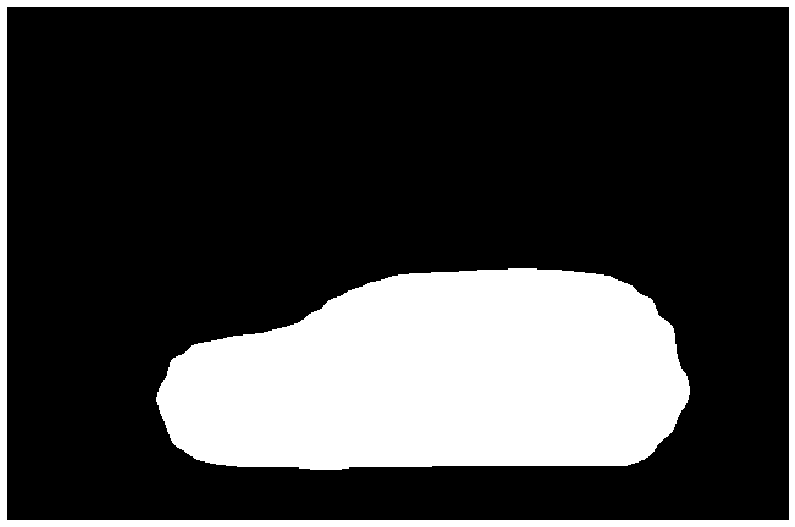

In [51]:
finalResult=obtenerSegmentacionConjunta2(result1,result2)
s.image_show(finalResult)

Evaluación de la segmentacion obtenida 

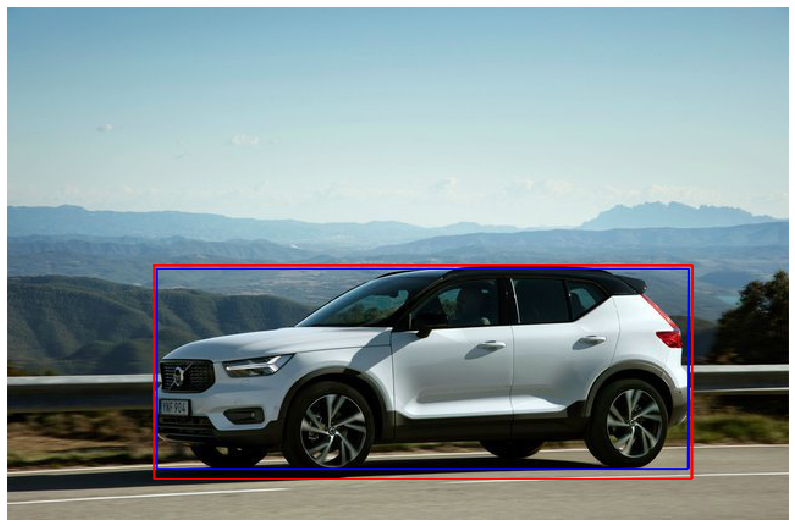

In [52]:
# Valores máximos y mínimos de las filas y columnas de los bordes del coche.
# Multiplicamos por 255 porque los valores del finalResult estan normalizados y la funcion getVertices trabaja con valores no normalizados
finalRectangle=s.getVertices(finalResult*255)
# Llamamos a la función dibujarCuadrado para obtener puntos del cuadrado ideal
fFinal,cFinal=s.dibujarCuadrado(finalRectangle)
# Vemos la intersection over union dibujada. El azul son los valores predichos y el rojo los valores reales
fig, ax = s.image_show(img)
ax.plot(fFinal, cFinal, 'b', lw=2);
ax.plot(fTruth,cTruth, 'r', lw=2)

In [57]:
def metricasEvaluacion(truth, predicted,TruthRectangle,predictedRectangle):
    from skimage.metrics import (adapted_rand_error,variation_of_information)
    error, precision, recall = adapted_rand_error(truth, predicted)
    splits, merges = variation_of_information(truth, predicted)
    iOverU=s.bb_intersection_over_union(predictedRectangle,TruthRectangle)
    print(f"Intersection over union: {iOverU}")
    print(f"Adapted Rand error: {error}")
    print(f"Adapted Rand precision: {precision}")
    print(f"Adapted Rand recall: {recall}")
    print(f"False Splits: {splits}")
    print(f"False Merges: {merges}")

Evaluación del algoritmo de iñigo

In [58]:
metricasEvaluacion(arrayEvaluacion,result1,TruthRectangle,predRectangle1)

Intersection over union: 0.9239238995395971
Adapted Rand error: 0.08008950205691567
Adapted Rand precision: 0.938075935586667
Adapted Rand recall: 0.9024352273096744
False Splits: 0.18858674024482552
False Merges: 0.3812481735208626


Evaluación algoritmo de Luis

In [59]:
metricasEvaluacion(arrayEvaluacion,result2,TruthRectangle,predRectangle2)

Intersection over union: 0.9268947963800905
Adapted Rand error: 0.0777577275914243
Adapted Rand precision: 0.9083946809850807
Adapted Rand recall: 0.9365185853392323
False Splits: 0.13771515381646005
False Merges: 0.3645809846854431


Metricas de evaluación del segmentador fusionado

In [60]:
metricasEvaluacion(arrayEvaluacion,finalResult,TruthRectangle,finalRectangle)

Intersection over union: 0.9268947963800905
Adapted Rand error: 0.0777577275914243
Adapted Rand precision: 0.9083946809850807
Adapted Rand recall: 0.9365185853392323
False Splits: 0.13771515381646005
False Merges: 0.3645809846854431


#### Conclusiones

Como cabría esperar, al ser solo dos segmentadores y en caso de empate, que uno prevalezca, el resultado final es exacto al de mejor puntuación IoU, el de Luis. Sin embargo, si hubiéramos podido contar con los otros dos restantes, intuimos que el resultado hubiera mejorado, ya que, si nos fijamos en las segmentaciones de los dos algoritmos al principio, al algoritmo de Luis le faltan unos pocos píxeles de la parte delantera y trasera del coche. Mientras que el de Iñigo coge píxeles del suelo que no son parte del coche. Contando con dos segmentadores más, seguramente habría mayoría en que los píxeles del suelo no son coche, por ejemplo.

También cabe mencionar que el algoritmo de Luis funciona con imágenes con mucha más densidad de coches (como, por ejemplo, imágenes de una avenida principal de una ciudad) con una precisión muy alta, como se ve en su notebook.